# Table of Contents

[1D Plot](#1d_plot)

[2D Plot](#2d_plot)

[Geo Plot](#geo_plot)

# Preparation

Put everything init/imports work into here

## Installs and Imports

In [ ]:
!pip install geopandas

In [35]:
from ipywidgets import *
from IPython.display import display
from IPython.html.widgets import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
plt.style.use('seaborn')

from json import load as jload
from urllib.request import urlopen
import seaborn as sns
from datetime import date, timedelta
import datetime
from shapely import wkt
import glob
import geopandas

from IPython.display import clear_output
from os.path import exists

## General Functions

In [36]:
def fetchAllQueries(q, email):
    # Set below variable to true if you only want to load the first page
    first_page_only = True

    done = False
    scroll_id = ""
    frames = []
    
    temp_req = q + "&email=" + email + "&fetch_all=TRUE"
    res = jload(urlopen(temp_req))
    scroll_id = res["_scroll_id"]
    
    frames.append(pd.json_normalize(res["hits"]))
    
    if not first_page_only:
      while not done:
          temp_req = "https://api.outbreak.info/covid19/query?scroll_id=" + scroll_id
          res = jload(urlopen(temp_req))
          
          if res.get("error"):
              done = True
              continue
              
          frames.append(pd.json_normalize(res["hits"]))
    
    return pd.concat(frames)

In [37]:
req = "https://api.outbreak.info/covid19/query?q="

def fetchAllQueriesCountry(q, country, email):
    # Set below variable to true if you only want to load the first page
    first_page_only = True

    request = q + "country_iso3:" + country + "&email=" + email + "&fetch_all=TRUE"
    result = jload(urlopen(request))
    scroll_id = result['_scroll_id']
    hits = result['hits']
    done = False

    frames = []
    frames.append(pd.json_normalize(hits))

    if not first_page_only:
      while not done:            
        request = "http://api.outbreak.info/covid19/query?scroll_id=" + scroll_id
        result = jload(urlopen(request))
        
        if result.get("error"): 
            break

        scroll_id = result['_scroll_id']
        
        frames.append(pd.json_normalize(result["hits"]))

    return pd.concat(frames)

In [38]:
def retrieveDate(date, email):
    req = "https://api.outbreak.info/covid19/query?q=date:" + date
    df = fetchAllQueries(req, email)
    df = df.rename(columns={'iso3': 'iso_a3'})
    df = df[df["iso_a3"].notna()]
    df = df[df["iso_a3"].apply(lambda x: not x.isnumeric())]
    df = df[df["iso_a3"].apply(lambda x: len(x) == 3)]

    return df

## Loading Data

In [ ]:
def loadData():
  return geopandas.GeoDataFrame(pd.read_pickle("outbreak_data.pkl.gz"), crs='epsg:4326')

In [ ]:
data = loadData()

## Geo Plot Init

### Geo Plots Functions

In [39]:
def calculateDaysSince(start, end):
    start_split = start.split("-") # index 0 is year, 1 is month, 2 is day
    end_split = end.split("-")
    
    start_date = date(int(start_split[0]), int(start_split[1]), int(start_split[2]))
    end_date = date(int(end_split[0]), int(end_split[1]), int(end_split[2]))
    
    return (end_date - start_date).days

In [40]:
def mapData(df, date, column, cmap, vmin, vmax):
  data = getDateFromData(df, date)

  fig, ax = plt.subplots(1, 1, figsize=(20,10))
  if vmin > vmax:
      print("Error: vmin is larger than vmax")
      return
  data.plot(column=column, ax=ax, legend=True, cmap=cmap, vmin=vmin, vmax=vmax)
  ax.set_axis_off()
  ax.set_title("The data for " + column + " on " + date)

In [41]:
def saveMap(df, date, column, cmap, vmax, name):
  data = getDateFromData(df, date)

  fig, ax = plt.subplots(1, 1, figsize=(20,10))
  data.plot(column=column, ax=ax, legend=True, cmap=cmap, vmin=0, vmax=vmax)
  ax.set_axis_off()
  ax.set_title("The data for " + column + " on " + date)

  fig.savefig(name)
  plt.close(fig)

In [42]:
def findMaxValueFromCol(df, column):
  m = 0

  for v in df[column]:
    if v > m:
      m = v
  
  return m

In [43]:
def getDateFromData(df, date):
  return df[df['date'] == date]

In [44]:
def stringifyDate(date):
  return date.strftime("%Y") + "-" + date.strftime("%m") + "-" + date.strftime("%d")

In [45]:
def datifyString(s):
  l = s.split("-")
  return date(int(l[0]), int(l[1]), int(l[2]))

In [46]:
def retrieveDateRange(first, last, email):
  result = list()

  start_date = datifyString(first)
  end_date = datifyString(last)
  diff = (end_date - start_date).days

  world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
  world = world[(world.pop_est>0) & (world.name!="Antarctica")]

  for i in range(diff + 1):
    date_now = start_date + timedelta(days=i)
    date_string = stringifyDate(date_now)

    df = None

    try:
      df = retrieveDate(date_string, email)
    except Exception as err:
      print("Looks like the data for " + date_string + " and any date after is not yet an available date in the outbreak.info database. Please try to load this date at a later date. The dates until the unavailable date have been loaded.")
      return result

    covid_world = pd.merge(world, df, how="inner", on="iso_a3")
    covid_world = covid_world.rename(columns={'geometry_x': 'geometry'})
    covid_world["percentConfirmed"] = covid_world.apply(lambda row: (row["confirmed"] / row["population"]), axis=1)
    covid_world["percentPopDead"] = covid_world.apply(lambda row: (row["dead"] / row["population"]), axis=1)
    covid_world["percentConfirmedDead"] = covid_world.apply(lambda row: (row["dead"] / row["confirmed"]) if row["confirmed"] != 0 else 0, axis=1)

    result.append(covid_world)

  return result

In [47]:
def mergeData(li):
  return geopandas.GeoDataFrame(pd.concat(li, ignore_index=True), crs=li[0].crs)

In [48]:
def getLastDateFromData(df):
  return pd.Series.to_list(df["date"].sort_values(ascending=False))[0]

In [49]:
def updateData(df, email):
  start_date = stringifyDate(datifyString(getLastDateFromData(df)) + timedelta(days=1))
  end_date = stringifyDate(date.today())

  li = [df]

  li += retrieveDateRange(start_date, end_date, email)

  return mergeData(li)

### Geo Plot Initialization

In [ ]:
date_range_start = datetime.datetime(2020, 1, 21)
last_date_string = getLastDateFromData(data)
last_date_int = [int(i) for i in last_date_string.split("-")]
date_range_end = datetime.datetime(last_date_int[0], last_date_int[1], last_date_int[2])

range_dates = pd.date_range(date_range_start, date_range_end, freq='D')

options = [(date.strftime(' %d %b %Y '), stringifyDate(date)) for date in range_dates]
index = (0, len(options)-1)

date_range_selector = widgets.SelectionRangeSlider(
    options=options,
    index=index,
    description='Dates',
    orientation='horizontal',
    layout={'width': '500px'}
)

In [51]:
color_options = [
            'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

color_selection = widgets.Dropdown(
    options=color_options,
    value='YlOrRd',
    description='Colormap:',
    disabled=False,
)

In [52]:
graphable_values = ["confirmed", "percentConfirmed", "confirmed_rolling", "dead", "percentPopDead", "percentConfirmedDead", "dead_rolling"]

value_selection = widgets.Dropdown(
    options=graphable_values,
    value='percentConfirmed',
    description='Value to Plot:',
    disabled=False,
)

In [53]:
vmax_selection = widgets.BoundedFloatText(
    value=0.0,
    min=0.0,
    max=100.0,
    step=1,
    description='vmax:',
    disabled=False
)

vmin_selection = widgets.BoundedFloatText(
    value=0.0,
    min=0.0,
    max=100.0,
    step=1,
    description='vmin:',
    disabled=False
)

## 1D Plot Init

### 1D Plot Functions

In [54]:
def readCheckboxes(checkboxes):
  return_list = []

  for key in checkboxes:
    if checkboxes[key].value == True:
      return_list.append(key)
  
  return return_list

In [55]:
COLUMNS = [["totals", "confirmed", "dead", "recovered"],
           ["doubling rate", "confirmed_doublingRate","dead_doublingRate","recovered_doublingRate"],
           ['numIncrease', "confirmed_numIncrease", "dead_numIncrease", "recovered_numIncrease"],
           ['numIncrease_per_100k', "confirmed_numIncrease_per_100k", "dead_numIncrease_per_100k", "recovered_numIncrease_per_100k"], #NOT INCLUDED FOR NOW
           ['pctIncrease', "confirmed_pctIncrease", "dead_pctIncrease", "recovered_pctIncrease"],
           ['per_100k', "confirmed_per_100k", "dead_per_100k", "recovered_per_100k"], #NOT INCLUDED FOR NOW
           ['rolling', "confirmed_rolling", "dead_rolling", "recovered_rolling"],
           ['rolling_14days_ago', "confirmed_rolling_14days_ago", "dead_rolling_14days_ago", "recovered_rolling_14days_ago"],
           ['rolling_14days_ago_diff', "confirmed_rolling_14days_ago_diff", "dead_rolling_14days_ago_diff", "recovered_rolling_14days_ago_diff"],
           ['rolling_14days_ago_diff_per_100k', "confirmed_rolling_14days_ago_diff_per_100k", "dead_rolling_14days_ago_diff_per_100k", "recovered_rolling_14days_ago_diff_per_100k"]] #NOT INCLUDED FOR NOW

created1DPlots = []

def graph1DPlot(res, plotTypes1D, var1D, varType1D, color1D, layerPlot1D):
  global title1D
  global created1DPlots
  if (var1D == 1):
    title1D = COLUMNS[varType1D][0] + " for confirmed cases"
  elif (var1D == 2):
    title1D = COLUMNS[varType1D][0] + " for dead cases"
  elif (var1D == 3):
    title1D = COLUMNS[varType1D][0] + " for recovered cases"

  global plotHist, plotKde, plotEcdf
  plotHist = 'histogram' in plotTypes1D
  plotKde = 'kernel density estimate' in plotTypes1D
  plotEcdf = 'empirical cumulative distribution function' in plotTypes1D

  created1DPlots = []

  if (plotHist):
    if (layerPlot1D):
      plo = sns.displot(data=res, x=COLUMNS[varType1D][var1D], color=color1D, kde=plotKde).set(title=title1D)
      created1DPlots.append(plo)
    else:
      plo = sns.displot(data=res, x=COLUMNS[varType1D][var1D], color=color1D).set(title=title1D)
      created1DPlots.append(plo)
      plo = sns.displot(data=res, x=COLUMNS[varType1D][var1D], color=color1D, kind="kde").set(title=title1D)
      created1DPlots.append(plo)
  else:
    if (plotKde):
      plo = sns.displot(data=res, x=COLUMNS[varType1D][var1D], color=color1D, kind="kde").set(title=title1D)
      created1DPlots.append(plo)
  if (plotEcdf):
    plo = sns.displot(data=res, x=COLUMNS[varType1D][var1D], color=color1D, kind="ecdf").set(title=title1D)
    created1DPlots.append(plo)

###1D Plot Initialization

In [56]:
VARS = [('confirmed', 1), ('dead', 2), ('recovered', 3)]
dropdownVar = widgets.Dropdown(options=VARS, value=None, description='Var:',)

In [57]:
VARTYPES = [('totals', 0), ('doubling rate', 1), ('numIncrease', 2), ('pctIncrease', 4), ('rolling', 6), ('rolling_14days_ago', 7), ('rolling_14days_ago_diff', 8)]
dropdownVarType = widgets.Dropdown(options=VARTYPES, value=None, description='Var Type:',)

In [58]:
COUNTRY = [('Canada', 'CAN'), ('Japan', 'JPN'), ('United States', 'USA'), ('Korea', 'KOR'), ('France', 'FRA')]
dropdownCountry = widgets.Dropdown(options=COUNTRY, value=None, description='Country:',)

In [59]:
PLOTTYPES1D = ['histogram', 'kernel density estimate', 'empirical cumulative distribution function']
checkboxes = dict()
checkboxPlotType = []

for option in PLOTTYPES1D:
  curr = widgets.Checkbox(
    value=False,
    description=option,
    disabled=False,
    indent=False
  )
  checkboxes[option] = curr
  checkboxPlotType.append(curr)

In [60]:
COLORS = ['red', 'blue', 'pink', 'black']
dropdownColor = widgets.Dropdown(options=COLORS, value=None, description='Color Palette:',)

In [61]:
dropdownLayerPlots = widgets.Dropdown(options=[('Yes', True), ('No', False)], description='Layer Plots?', disabled=False)

In [62]:
def generate1DPlot(b):
  var1D = dropdownVar.value
  varType1D = dropdownVarType.value
  country1D = dropdownCountry.value
  color1D = dropdownColor.value
  layerPlot1D = dropdownLayerPlots.value

  plotTypes1D = readCheckboxes(checkboxes)

  if var1D == None:
    print("Invalid var selected")
    return
  elif varType1D == None:
    print("Invalid var type selected")
    return
  elif country1D == None:
    print("Invalid country selected")
    return
  elif color1D == None:
    print("Invalid color selected")
    return
  elif layerPlot1D == None:
    print("Invalid option selected")
    return
  elif textEmail.value == None:
    print("Invalid email")
    return

  data = None


  data_path = country1D + ".pkl.gz"
  if exists(data_path):
    data = pd.read_pickle(data_path)
  else:
    print(data_path + " does not exist, please wait while the data loads")
    data = fetchAllQueriesCountry(req, country1D, textEmail.value)
    data.to_pickle(data_path)

  data = data[~data.index.duplicated()]

  graph1DPlot(data, plotTypes1D, var1D, varType1D, color1D, layerPlot1D)

generate_graph_button = widgets.Button(description="Generate Graph")
generate_graph_button.on_click(generate1DPlot)

In [63]:
def save1DPlot(b):
  global created1DPlots
  for i in range(len(created1DPlots)):
    created1DPlots[i].fig.savefig(str(i) + file_name_1d.value)

file_name_1d = widgets.Text()
file_name_1d.value = "exampleFileName1D.pdf"

save_1d_graph_button = widgets.Button(description="Save Graphs")
save_1d_graph_button.on_click(save1DPlot)
file_name_1d.on_submit(save1DPlot)

## 2D Plot Init

###2D Plot Functions

In [64]:
def readCheckboxes(checkboxes):
  return_list = []

  for key in checkboxes:
    if checkboxes[key].value == True:
      return_list.append(key)
  
  return return_list

In [65]:
COLUMNS = [["totals", "confirmed", "dead", "recovered"],
           ["doubling rate", "confirmed_doublingRate","dead_doublingRate","recovered_doublingRate"],
           ['numIncrease', "confirmed_numIncrease", "dead_numIncrease", "recovered_numIncrease"],
           ['numIncrease_per_100k', "confirmed_numIncrease_per_100k", "dead_numIncrease_per_100k", "recovered_numIncrease_per_100k"], #NOT INCLUDED FOR NOW
           ['pctIncrease', "confirmed_pctIncrease", "dead_pctIncrease", "recovered_pctIncrease"],
           ['per_100k', "confirmed_per_100k", "dead_per_100k", "recovered_per_100k"], #NOT INCLUDED FOR NOW
           ['rolling', "confirmed_rolling", "dead_rolling", "recovered_rolling"],
           ['rolling_14days_ago', "confirmed_rolling_14days_ago", "dead_rolling_14days_ago", "recovered_rolling_14days_ago"],
           ['rolling_14days_ago_diff', "confirmed_rolling_14days_ago_diff", "dead_rolling_14days_ago_diff", "recovered_rolling_14days_ago_diff"],
           ['rolling_14days_ago_diff_per_100k', "confirmed_rolling_14days_ago_diff_per_100k", "dead_rolling_14days_ago_diff_per_100k", "recovered_rolling_14days_ago_diff_per_100k"]] #NOT INCLUDED FOR NOW

created2DPlots = []

def graph2DPlot(res, plotTypes2D, varX2D, varY2D, varType2D, color2D, marker2D, alpha2D):
  global xtitle, ytitle
  global created2DPlots
  if (varX2D == 1): xtitle = "confirmed"
  elif (varX2D == 2): xtitle = "dead"
  elif (varX2D == 3): xtitle = "recovered"
  if (varY2D == 1): ytitle = "confirmed"
  elif (varY2D == 2): ytitle = "dead"
  elif (varY2D == 3): ytitle = "recovered"
  title2D = COLUMNS[varType2D][0] + " for " + xtitle + " vs " + ytitle + " cases"

  global plotScatter, plotLine, plotReg
  plotScatter = 'scatterplot' in plotTypes2D
  plotLine = 'line plot' in plotTypes2D
  plotReg = 'regression' in plotTypes2D

  created2DPlots = []

  if (plotScatter):
    plo = sns.scatterplot(data=res, x=COLUMNS[varType2D][varX2D], y=COLUMNS[varType2D][varY2D], color=color2D, marker=marker2D, alpha=alpha2D)
    plo.set(title=title2D)
    created2DPlots.append(plo.figure)
  if (plotReg):
    plo = sns.regplot(data=res, x=COLUMNS[varType2D][varX2D], y=COLUMNS[varType2D][varY2D], color=color2D, order=1, marker=marker2D, scatter_kws={'alpha':alpha2D})
    plo.set(title=title2D)
    created2DPlots.append(plo.figure)
  if (plotLine):
    plo = sns.relplot(data=res, x=COLUMNS[varType2D][varX2D], y=COLUMNS[varType2D][varY2D], color=color2D, kind='line', marker=marker2D)
    plo.set(title=title2D)
    created2DPlots.append(plo.fig)

### 2D Plot Initialization

In [66]:
VARS2D = [('confirmed', 1), ('dead', 2), ('recovered', 3)]
dropdownVarX = widgets.Dropdown(options=VARS2D, value=None, description='Var X:')
global dropdownVarY
dropdownVarY = widgets.Dropdown(options=VARS2D, value=None, description='Var Y:')

In [67]:
VARTYPES2D = [('totals', 0), ('doubling rate', 1), ('numIncrease', 2), ('pctIncrease', 4), ('rolling', 6), ('rolling_14days_ago', 7), ('rolling_14days_ago_diff', 8)]
dropdownVarType2D = widgets.Dropdown(options=VARTYPES2D, value=None, description='Var Type:',)

In [68]:
COUNTRY2D = [('Canada', 'CAN'), ('Japan', 'JPN'), ('United States', 'USA'), ('Korea', 'KOR'), ('France', 'FRA')]
dropdownCountry2D = widgets.Dropdown(options=COUNTRY2D, value=None, description='Country:',)

In [69]:
PLOTTYPES2D = ['scatterplot', 'line plot', 'regression']
checkboxes2D = dict()
checkboxPlotType2D = []

for option in PLOTTYPES2D:
  curr = widgets.Checkbox(
    value=False,
    description=option,
    disabled=False,
    indent=False
  )
  checkboxes2D[option] = curr
  checkboxPlotType2D.append(curr)

In [70]:
COLORS = ['red', 'blue', 'pink', 'black']
dropdownColor2D = widgets.Dropdown(options=COLORS, value=None, description='Color Palette:',)

In [71]:
MARKERS = [('point', '.'), ('circle', 'o'), ('triangle down', 'v'), ('triangle up', '^'), ('square', 's'), ('plus', 'P'), ('star', '*'), ('x', 'X'), ('diamond', 'D')]
dropdownMarker2D = widgets.Dropdown(options=MARKERS, value=None, description='Marker Type:')

In [72]:
textTransparent2D = widgets.Text(value='1')

In [73]:
def generate2DPlot(b):
  varX2D = dropdownVarX.value
  varY2D = dropdownVarY.value
  varType2D = dropdownVarType2D.value
  country2D = dropdownCountry2D.value
  color2D = dropdownColor2D.value
  marker2D = dropdownMarker2D.value
  alpha2D = float(textTransparent2D.value)

  plotTypes2D = readCheckboxes(checkboxes2D)

  if varX2D == None:
    print("Invalid var x selected")
    return
  elif varY2D == None:
    print("Invalid var y selected")
    return
  elif varType2D == None:
    print("Invalid var type selected")
    return
  elif country2D == None:
    print("Invalid country selected")
    return
  elif color2D == None:
    print("Invalid color selected")
    return
  elif marker2D == None:
    print("Invalid marker selected")
    return
  elif (alpha2D < 0 or alpha2D > 1):
    print("Invalid transparency value entered")
    return
  elif textEmail.value == None:
    print("Invalid email")
    return

  data = None

  data_path = country2D + ".pkl.gz"
  if exists(data_path):
    data = pd.read_pickle(data_path)
  else:
    print(data_path + " does not exist, please wait while the data loads")
    data = fetchAllQueriesCountry(req, country2D, textEmail.value)
    data.to_pickle(data_path)

  data = data[~data.index.duplicated()] 

  graph2DPlot(data, plotTypes2D, varX2D, varY2D, varType2D, color2D, marker2D, alpha2D)

generate_twod_graph_button = widgets.Button(description="Generate Graph")
generate_twod_graph_button.on_click(generate2DPlot)

In [74]:
def save2DPlot(b):
  global created2DPlots
  for i in range(len(created2DPlots)):
    created2DPlots[i].savefig(str(i) + file_name_2d.value)

file_name_2d = widgets.Text()
file_name_2d.value = "exampleFileName2D.pdf"

save_2d_graph_button = widgets.Button(description="Save Graphs")
save_2d_graph_button.on_click(save2DPlot)
file_name_2d.on_submit(save2DPlot)

# Email

In [75]:
#@title
textEmail = widgets.Text()

print("Enter email here:")
display(textEmail)

Enter email here:


Text(value='')

<a name="1d_plot"></a>
# One-Dimensional Plots

Dropdown(description='Var:', options=(('confirmed', 1), ('dead', 2), ('recovered', 3)), value=None)

Dropdown(description='Var Type:', options=(('totals', 0), ('doubling rate', 1), ('numIncrease', 2), ('pctIncre…

Dropdown(description='Country:', options=(('Canada', 'CAN'), ('Japan', 'JPN'), ('United States', 'USA'), ('Kor…


Select Type of 1D Plot:


Checkbox(value=False, description='histogram', indent=False)

Checkbox(value=False, description='kernel density estimate', indent=False)

Checkbox(value=False, description='empirical cumulative distribution function', indent=False)

Dropdown(description='Layer Plots?', options=(('Yes', True), ('No', False)), value=True)

Dropdown(description='Color Palette:', options=('red', 'blue', 'pink', 'black'), value=None)

Button(description='Generate Graph', style=ButtonStyle())

JPN.pkl.gz does not exist, please wait while the data loads


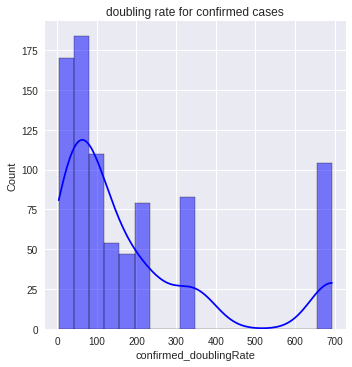

In [76]:
#@title
display(dropdownVar)
display(dropdownVarType)
display(dropdownCountry)
print()

print('Select Type of 1D Plot:')
for checkbox in checkboxPlotType:
  display(checkbox)
print()

display(dropdownLayerPlots)

display(dropdownColor)
print()

display(generate_graph_button)

In [77]:
#@title
display(file_name_1d)
display(save_1d_graph_button)

Text(value='exampleFileName1D.pdf')

Button(description='Save Graphs', style=ButtonStyle())

<a name="2d_plot"></a>
#Two-Dimensional Plots

Dropdown(description='Var X:', options=(('confirmed', 1), ('dead', 2), ('recovered', 3)), value=None)

Dropdown(description='Var Y:', options=(('confirmed', 1), ('dead', 2), ('recovered', 3)), value=None)

Dropdown(description='Var Type:', options=(('totals', 0), ('doubling rate', 1), ('numIncrease', 2), ('pctIncre…

Dropdown(description='Country:', options=(('Canada', 'CAN'), ('Japan', 'JPN'), ('United States', 'USA'), ('Kor…


Select Type of 2D Plot:


Checkbox(value=False, description='scatterplot', indent=False)

Checkbox(value=False, description='line plot', indent=False)

Checkbox(value=False, description='regression', indent=False)

Dropdown(description='Color Palette:', options=('red', 'blue', 'pink', 'black'), value=None)

Dropdown(description='Marker Type:', options=(('point', '.'), ('circle', 'o'), ('triangle down', 'v'), ('trian…


Enter Alpha Value for Marker Transparency (Floating Number from 0 to 1):


Text(value='1')

Button(description='Generate Graph', style=ButtonStyle())

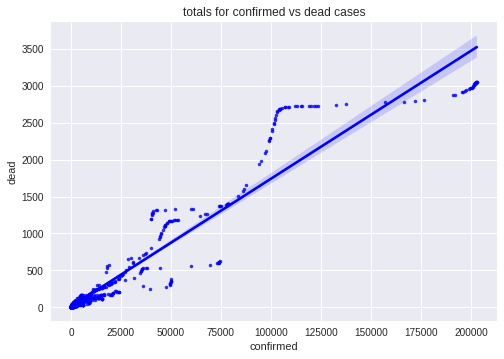

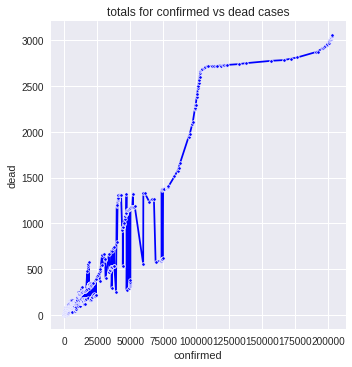

In [78]:
#@title
display(dropdownVarX)
display(dropdownVarY)

display(dropdownVarType2D)
display(dropdownCountry2D)
print()

print('Select Type of 2D Plot:')
for checkbox2D in checkboxPlotType2D:
  display(checkbox2D)
print()

display(dropdownColor2D)
display(dropdownMarker2D)
print()

print('Enter Alpha Value for Marker Transparency (Floating Number from 0 to 1):')
display(textTransparent2D)

display(generate_twod_graph_button)

In [79]:
#@title
display(file_name_2d)
display(save_2d_graph_button)

Text(value='exampleFileName2D.pdf')

Button(description='Save Graphs', style=ButtonStyle())

<a name="geo_plot"></a>
# Geo Plot

In [ ]:
#@title
display(date_range_selector)
display(color_selection)

vmax = findMaxValueFromCol(data, value_selection.value)
def changeVmax(value):
  global vmax
  vmax = findMaxValueFromCol(data, value_selection.value)
  vmax_selection.max = vmax
  vmin_selection.max = vmax
  vmax_selection.value = vmax
  vmin_selection.value = 0.0
valueInteract = interact(changeVmax, value=value_selection)

display(vmin_selection)
display(vmax_selection)

print("\nThe date range is chosen based off the first and last data point in the current data. If you would like data from a later date, press the 'Update Data' button. \nPlease note that the database may not be up to date with today's date.\nAfter the data has been updated, you may want to rerun all cells.")
update_data_button = widgets.Button(description="Update Data")
display(update_data_button)

def updateDataToRecent(b):
  global data
  data = updateData(data, "gxcheng@ucsd.edu")
  data.to_pickle("outbreak_data.pkl.gz")

update_data_button.on_click(updateDataToRecent)

SelectionRangeSlider(description='Dates', index=(0, 663), layout=Layout(width='500px'), options=((' 21 Jan 202…

Dropdown(description='Colormap:', index=7, options=('Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', …

interactive(children=(Dropdown(description='Value to Plot:', index=1, options=('confirmed', 'percentConfirmed'…

BoundedFloatText(value=0.0, description='vmin:', max=0.23669286436853162, step=1.0)

BoundedFloatText(value=0.23669286436853162, description='vmax:', max=0.23669286436853162, step=1.0)


The date range is chosen based off the first and last data point in the current data. If you would like data from a later date, press the 'Update Data' button. 
Please note that the database may not be up to date with today's date.
After the data has been updated, you may want to rerun all cells.


Button(description='Update Data', style=ButtonStyle())

Looks like the data for 2021-11-15 and any date after is not yet an available date in the outbreak.info database. Please try to load this date at a later date. The dates until the unavailable date have been loaded.


In [ ]:
#@title
start_date = date_range_selector.value[0]
end_date = date_range_selector.value[1]

dates = pd.date_range(start_date, end_date, freq='D')

options = [stringifyDate(date) for date in dates]

date_selection_slider = widgets.SelectionSlider(
    options=options,
    value=options[0],
    description='Date',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    layout={'width': '500px'}
)

def displayMap(date):
  mapData(data, date, value_selection.value, color_selection.value, vmin_selection.value, vmax_selection.value)
mapInteract = interact(displayMap,date=date_selection_slider)

# try to load the data
# if it doesn't load / can't find it, then load the dates
# when loading dates, print what the latest date was

interactive(children=(SelectionSlider(description='Date', layout=Layout(width='500px'), options=('2020-01-21',…

In [ ]:
#@title
# add text widget, if you press enter -> text will be printed
file_name = widgets.Text()
display(file_name)
file_name.value = "exampleFileName.pdf"

# add button widget, if you click -> text will be
save_map_button = widgets.Button(description="Save Map")
display(save_map_button)

def saveMapData(b):
  saveMap(data, date_selection_slider.value, value_selection.value, color_selection.value, vmax, file_name.value)

save_map_button.on_click(saveMapData)
file_name.on_submit(saveMapData)

Text(value='')

Button(description='Save Map', style=ButtonStyle())